<a href="https://colab.research.google.com/github/agdylan/research_code/blob/main/Register_MNIST_5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --no-dependencies icon_registration==1.1.2

In [2]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

100%|██████████| 9912422/9912422 [00:00<00:00, 189254063.80it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 125269590.30it/s]


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86878691.98it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18936907.32it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



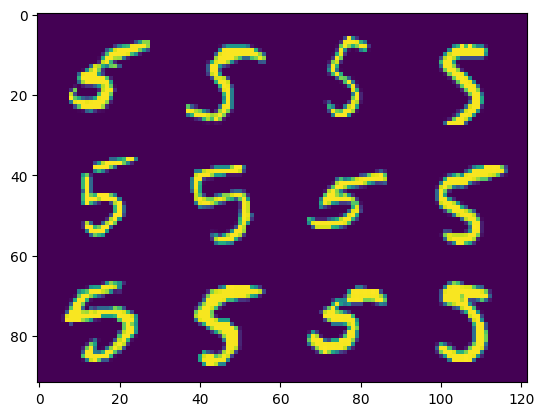

In [3]:
ds, _ = icon_registration.data.get_dataset_mnist(split="train", number=5)

sample_batch = next(iter(ds))[0]
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [4]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
     inner_net = icon.TwoStepRegistration(
         icon.DownsampleRegistration(inner_net, dimension=2),
         icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
     )

net = icon.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=.5) # Here we can change the regularizers that we are usuing
# Ex: icon.bendingenergy, icon.diffusion
# Gradicon is expected to have greater variation between training so this is what we are testing for
# Look in the paper for the best values for the inputs
net.assign_identity_map(sample_batch.shape)

100%|██████████| 5/5 [01:21<00:00, 16.22s/it]


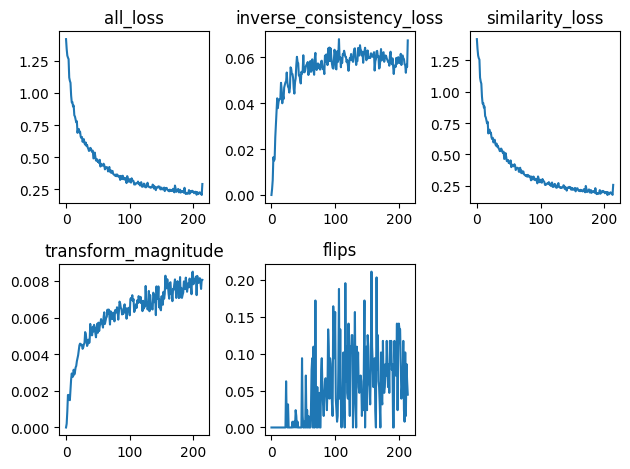

In [5]:
net.train()
net.to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)
curves = icon.train_datasets(net, optim, ds, ds, epochs=5)
for i, name in enumerate(curves[0]._fields):
  plt.subplot(2, 3, i + 1)
  plt.plot([getattr(c, name) for c in curves])
  plt.title(name)
plt.tight_layout()

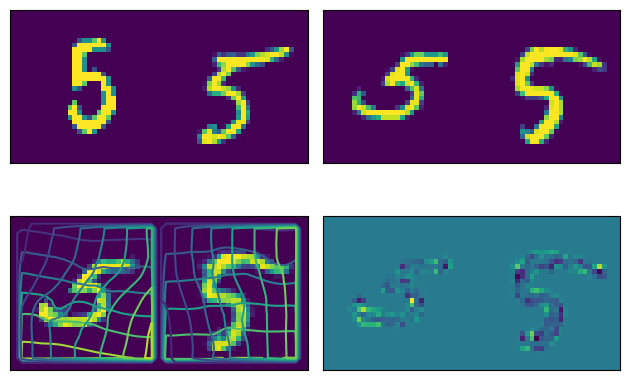

In [10]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:2], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
image_A = next(iter(ds))[0].to(device)
image_B = next(iter(ds))[0].to(device)
net(image_A, image_B) # call network on the images to get outputs
plt.subplot(2, 2, 1)
show(image_A)
plt.subplot(2, 2, 2)
show(image_B)
plt.subplot(2, 2, 3)
show(net.warped_image_A)
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[0].cpu().detach()) # Draws vertical grid lines
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[1].cpu().detach()) # Draws horiziontal grid lines
plt.subplot(2, 2, 4)
show(net.warped_image_A - image_B)
plt.tight_layout()

# Running to see if the lines in the bottom left are goiing to be different each time
# Most interesting thing would be create a heat map for each regularization technique
# 30 trials for each of the regularizers, GradIcon, Diffusion, Bending Energy

# Generating the heat map
# Curious about the statistical properties of the vectors and the covariance matrix
# Expectation is the vectors are similar to each other for diffusion and different for GradIcon
# Final product targeting is a pdf writeup describing the question and looking into the literature about what people have said before about network training, comparing Gradicon to other techniques

In [11]:
net.phi_AB_vectorfield # This is what we are investigating. Neural network is investigated batch of 128 at a time
# Focus on a single random chosen pair of images
#


# Structure
# pick two batches of images and save those on disk with torch.save
# train 30 networks with a for loop
# Call each of those networks on batches of images so the inputs are the ame but netowrks differ
# Stack vector fields into a new tensor with shape 30,128,28,28
# Compute the variance of the tensor and you will have tensor of 128,2,2,128
# Draw a heat map for one of the 128 images in the map

tensor([[[[-1.4220e-02, -1.6868e-02, -2.2505e-02,  ..., -8.3200e-02,
           -8.2915e-02, -8.3220e-02],
          [ 3.1006e-02,  2.8081e-02,  1.9995e-02,  ..., -4.2781e-02,
           -4.4776e-02, -4.6797e-02],
          [ 7.4818e-02,  7.0182e-02,  6.1584e-02,  ..., -6.5593e-03,
           -8.6777e-03, -1.2208e-02],
          ...,
          [ 1.0429e+00,  1.0449e+00,  1.0451e+00,  ...,  9.0564e-01,
            9.0387e-01,  9.0035e-01],
          [ 1.0736e+00,  1.0781e+00,  1.0820e+00,  ...,  9.4904e-01,
            9.4671e-01,  9.4448e-01],
          [ 1.1078e+00,  1.1128e+00,  1.1166e+00,  ...,  9.9239e-01,
            9.9045e-01,  9.8556e-01]],

         [[-4.9452e-02, -1.4474e-02,  1.4772e-02,  ...,  7.0805e-01,
            7.5021e-01,  7.9103e-01],
          [-4.4765e-02, -7.1903e-03,  2.1724e-02,  ...,  7.0982e-01,
            7.4973e-01,  7.8949e-01],
          [-3.8095e-02, -9.3333e-04,  2.9058e-02,  ...,  7.0708e-01,
            7.4811e-01,  7.8726e-01],
          ...,
     